# 2.5 Lucas Tree

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from scipy import optimize as opt
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Generating and cleaning data

In [6]:
class DataSet(object):

    def __init__(self):
        self.start = datetime.datetime(1971, 1, 1)
        self.current = datetime.datetime.now()
        
        self.rpce = web.DataReader('PCECC96', 'fred', self.start, self.current)
        self.w5000 = web.DataReader('WILL5000INDFC', 'fred', self.start, self.current)
        self.gdp_def = web.DataReader('GDPDEF', 'fred', self.start, self.current)
        self.tbill = web.DataReader('TB3MS', 'fred', self.start, self.current)
        self.df = self.__create_table()
        
    def __create_table(self):
        self.tbill = self.tbill.resample('QS').first()
        self.w5000 = self.w5000.resample('QS').first()
        
        # following code motivated by:
        # https://stackoverflow.com/questions/40433717/pandas-how-to-use-groupby-to-group-columns-by-date-in-the-label
        df = pd.concat([self.rpce, self.w5000, self.gdp_def, self.tbill], sort=False)
        df = df.groupby(pd.PeriodIndex(df.index, freq='Q'), axis=0).mean() 
        df.columns = ['rpce', 'w5000', 'GDP_def', 'tbill']
        df['r_w5000'] = df['w5000'] / df['GDP_def'] * 100
        df['R'] = df['r_w5000'] / df['r_w5000'].shift(1)
        df['tbill'] = df['tbill'] / 100 + 1
        df.dropna(axis=0, inplace=True)
        return df
    
    def update(self):
        self.__init__()        

In [3]:
dataset = DataSet()

In [4]:
dataset.df.head()

,rpce,w5000,GDP_def,tbill,r_w5000,R
DATE,,,,,,
1971Q2,3185.993,1.16,22.685,1.0386,5.113511,1.090444
1971Q3,3211.394,1.09,22.916,1.0540,4.756502,0.930183
1971Q4,3264.679,1.08,23.107,1.0446,4.673908,0.982636
1972Q1,3307.767,1.21,23.458,1.0338,5.158155,1.103606
1972Q2,3370.736,1.27,23.604,1.0371,5.380444,1.043095


### Question 1

In [13]:
class GMM1(object):
    def __init__(self, df):
        self.beta = 0.99
        self.df = df
    
    def __get_SDF(self, df, gamma, beta):
        mu = self.df.rpce ** (-gamma)
        return (beta * mu.shift(-1) / mu)[:-1]
    
    def __objective(self, gamma):
        R = self.df.R[1:]
        m = self.__get_SDF(self.df, gamma, self.beta)
        cov_mR = m.cov(R)
        err = cov_mR + np.mean(m) * np.mean(R) - 1
        return err
    
    def solve_gamma(self, gamma_guess):
        result = opt.broyden1(self.__objective, gamma_guess)
        return result

In [14]:
Problem2 = GMM1(dataset.df)
Problem2.solve_gamma(0.99)

array(1.28216356)

### Question 2

I can check if the parameter is reasonable by following the same procedure, but using other datasets. I can also estimate the value of $\gamma$ using other equations like in question 3.

### Question 3

In [25]:
class GMM2(object):
    def __init__(self, df):
        self.beta = 0.99
        self.df = df
        
    def __get_SDF(self, df, gamma, beta):
        mu = self.df.rpce ** (-gamma)
        return (beta * mu.shift(-1) / mu)[:-1]
    
    def __objective(self, gamma):
        rf = self.df.tbill[1:]
        m = self.__get_SDF(self.df, gamma, self.beta)
        err = rf - 1 / np.mean(m)
        return np.sum(err ** 2)
    
    def solve_gamma(self, gamma_guess): 
        result = opt.root(self.__objective, gamma_guess)
        return result.x

In [26]:
Problem3 = GMM2(dataset.df)
Problem3.solve_gamma(.99)

array([4.81928546])

This $\gamma$ value is very different from that estimated in question 2.

### Question 4

In [28]:
class GMM3(object):
    def __init__(self, df):
        self.df = df
        self.W = np.eye(2)
        
    def __SDF(self, df, gamma, beta):
        mu = df.rpce ** (-gamma)
        return (beta * mu.shift(-1) / mu)[:-1]
    
    def __data_moments(self, gamma, beta):
        m = self.__SDF(self.df, gamma, beta)
        R = self.df.R[1:]
        cov_mR = m.cov(R)
        err1 = cov_mR + np.mean(m) * np.mean(R) - 1
        mm1 = err1
        
        rf = self.df.tbill[1:]
        err2 = rf - 1 / np.mean(m)
        mm2 = np.sum(err2 ** 2)
        
        return mm1, mm2

    def __err_vec(self, gamma, beta, simple=True):
        mm1, mm2 = self.__data_moments(gamma, beta)
        data_mms = np.array([mm1, mm2])
        model_mms = np.array([0, 0])
        err_vec = model_mms - data_mms
        return err_vec
    
    def __criterion(self, params):
        gamma, beta = params
        err = self.__err_vec(gamma, beta)
        crit_val = err.T @ self.W @ err
        return crit_val
    
    def solve_params(self, gamma_guess, beta_guess):
        params_init = np.array([gamma_guess, beta_guess])
        bnds = ((1e-10, None), (1e-10, 1))
        result = opt.minimize(self.__criterion, params_init, bounds = bnds, method = 'L-BFGS-B')
        return result
    
    def plot(self):
        N = 50
        gamma_grid = np.linspace(1, 5, N)
        beta_grid = np.linspace(0.95, 1, N)
        gmm_vals = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                gamma, beta = gamma_grid[i], beta_grid[i]
                params = (gamma, beta)
                gmm_vals[i,j] = self.__criterion(params)
                
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca(projection='3d')
        GAMMA, BETA = np.meshgrid(gamma_grid, beta_grid)
        surf = ax.plot_wireframe(GAMMA, BETA, gmm_vals.T)
        ax.set_xlabel(r'$\gamma$')
        ax.set_ylabel(r'$\beta$')
        ax.set_title("Objective Function")
        #plt.show()

In [29]:
problem4 = GMM3(dataset.df)
problem4.solve_params(4, 0.99)

      fun: 0.05130964735629778
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.46715451e-06, -3.92394450e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 2
   status: 0
  success: True
        x: array([4.00004538, 0.98440937])

<IPython.core.display.Javascript object>


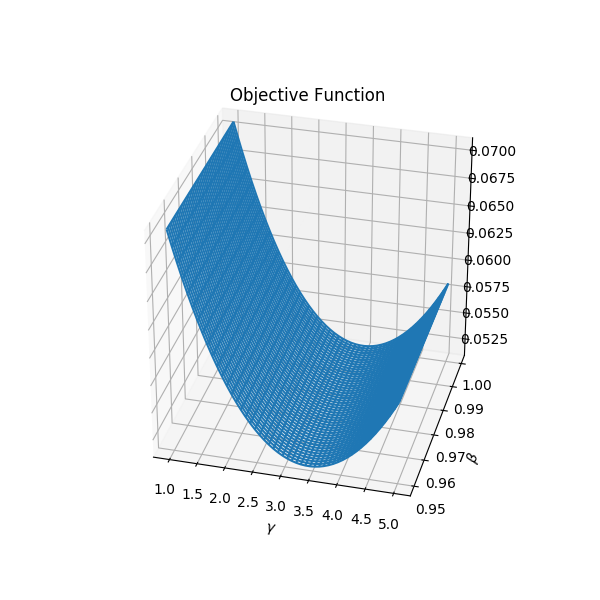

In [30]:
problem4.plot()

The estimation is very different from the previous two ways of estimating the parameters because this method is much more vairable to the initial guess. This can be explained from the plot of the objective function for different $(\beta, \gamma)$ pairs. It can be seen that there is no clear global minimum making it very susceptible to the initial guess.